In [2]:
import networkx as nx
import numpy as np
import pandas as pd
import csv as csv
import datetime
import ast

from sklearn.metrics.pairwise import cosine_similarity

import sklearn.preprocessing

Let's create a network using our new files, and the genereted text vectors from USE as link weights. We probably have to normalize the values however. 

In [3]:
pre_creation_stats_dict = {}

In [4]:
import pickle

drug_dict_list = None
protein_dict_list = None

use_drug_vectors = None
use_protein_vectors = None

with open("data/DPI_enriched.csv", "r") as dpi_file:
    drug_dict_list = [{k: v for k,v in row.items()}  for row in csv.DictReader(dpi_file, skipinitialspace=True)]

with open("data/PPI_enriched.csv", "r") as ppi_file:
    protein_dict_list = [{k: v for k,v in row.items()} for row in csv.DictReader(ppi_file, skipinitialspace=True)]

with open("embeddings/use_drug_vectors_pckl", "rb") as use_drug_file:
    use_drug_vectors = pickle.load(use_drug_file)

with open("embeddings/use_protein_vectors_pckl", "rb") as use_protein_file:
    use_protein_vectors = pickle.load(use_protein_file)

pre_creation_stats_dict["drug_dict_list_size"] = len(drug_dict_list)
pre_creation_stats_dict["protein_dict_list_size"] = len(protein_dict_list)

In [5]:
for i, vector in enumerate(use_drug_vectors):
    drug_dict_list[i]["description_vector"] = vector

for i, vector in enumerate(use_protein_vectors): 
    protein_dict_list[i]["function_vector"] = vector


In [6]:
from sklearn.preprocessing import normalize

def normalize_use_vectors(vector_list1, vector_list2):
    append_list = []
    for vector in vector_list1:
        append_list.append(vector[0])

    for vector in vector_list2:
        append_list.append(vector[0])

    norm_list = normalize(append_list, norm="l2")

    norm_list1 = norm_list[:len(vector_list1-1)]
    norm_list2 = norm_list[len(vector_list1-1):]

    return norm_list1, norm_list2


To normalize or not to normalize? 

In [ ]:
# print(len(use_drug_vectors))
# print(len(use_protein_vectors))

# check1, check2 = normalize_use_vectors(use_drug_vectors, use_protein_vectors)

# print(len(check1))
# print(len(check2))

# use_drug_vectors = check1
# use_protein_vectors = check2

In [7]:
def get_target_list(bad_format):
    targets = bad_format

    targets = targets.replace('[', '')
    targets = targets.replace(']', '')
    
    # Now remove ""
    targets = targets.replace('\'', '')

    #Split on comma
    targets = [x.strip() for x in targets.split(',')]
    #Remove the empty string
    targets = list(filter(None, targets))

    return targets 


In [8]:
def calculate_text_vector_sim_old(node1, node2, i, sim_type):
     if sim_type == "drug_target":
          a = use_drug_vectors[i]
          b = None
          
          for j, target in enumerate(protein_dict_list):
               if target["uniprot_id"] == node2:
                    b = use_protein_vectors[j]
                    break

          return np.linalg.norm(a-b)
     
     if sim_type == "protein_protein":
          a = use_protein_vectors[i]
          b = None

          for j, protein in enumerate(protein_dict_list):
               if protein["uniprot_id"] == node2:
                    b = use_protein_vectors[j]
                    break
                    
          return np.linalg.norm(a-b)


In [9]:
def calculate_text_vector_sim(node1, node2, i, sim_type):
    if sim_type == "drug_target":
        a = use_drug_vectors[i]
        b = None
        
        for j, target in enumerate(protein_dict_list):
            if target["uniprot_id"] == node2:
                b = use_protein_vectors[j]
                break
        temp = cosine_similarity(a, b)[0][0]
        return temp
     
    if sim_type == "protein_protein":
        a = use_protein_vectors[i]
        b = None

        for j, protein in enumerate(protein_dict_list):
            if protein["uniprot_id"] == node2:
                b = use_protein_vectors[j]
                break

        temp = cosine_similarity(a, b)[0][0]
        return temp

In [10]:
def save_graph_to_graphml(graph: nx.Graph, name: str):
    now = datetime.datetime.now()
    time = now.strftime("%Y-%m-%d-%H:%M:%S")
    nx.write_graphml(graph, "networks/" + name + "_" + time + ".graphml")

In [11]:
def check_protein_is_target(known_targets, current_protein, target_counter = 0):
    if current_protein["type"] == "target" or current_protein["uniprot_id"] in known_targets:
        target_counter += 1
        return True
    else:
        return False

In [12]:
print(len(drug_dict_list))
print(len(protein_dict_list))

3267
14852


In [ ]:
# print(drug_dict_list[0])

# print(protein_dict_list[0])

In [13]:
drugs_with_desc = set()
for drug in drug_dict_list:
    drugs_with_desc.add(drug["db_id"])

print(len(drugs_with_desc))

3267


In [14]:
proteins_with_desc = set()
for protein in protein_dict_list:
    proteins_with_desc.add(protein["uniprot_id"])

print(len(proteins_with_desc))

14852


In [15]:
def remove_isolated_nodes(graph: nx.Graph, isolated_nodes = []):
    # Remove nodes that have node degree 0
    # And remove nodes that only self loop, and don't have any other edges, 
    # we can do that by checking node degree > 1

    network_nodes = list(graph.nodes(data=True))
    self_loop_nodes = [val[0] for val in list(nx.selfloop_edges(graph))]

    for node_seq in network_nodes:
        node = node_seq[0]
        if graph.degree(node) == 0:
            graph.remove_node(node)
            isolated_nodes.append(node_seq)
            continue
        
        if graph.degree(node) == 2 and node in self_loop_nodes:
            graph.remove_node(node)
            isolated_nodes.append(node_seq)
            continue

    # These are some weirdo proteins that form a singular subgraph that we don't want so let's remove them
    WEIRDOS = ["Q5T4W7", "O60609", "O60542", "Q9GZZ7", "Q8IYV9", "A6ND01"]
    graph.remove_nodes_from(WEIRDOS)

    isolated_nodes.append(weird for weird in WEIRDOS)
    
    return graph
    

In [16]:
def create_networkx_graph_from_data(save: bool):
    dppi_graph: nx.Graph = nx.empty_graph()

    #First iterate through drugs 
    known_targets = set()
    for i, drug in enumerate(drug_dict_list):
        drug_node = drug["db_id"]
        dppi_graph.add_node(drug_node, type="drug")

        #Create target list from bad formatting in file
        # Remove brackets from targets
        targets = get_target_list(drug["targets"])
        
        for target in targets:
            if target in proteins_with_desc:
                known_targets.add(target)
                dppi_graph.add_node(target, type="target")
                dppi_graph.add_weighted_edges_from([(drug_node, target, 
                                                    calculate_text_vector_sim(drug_node, target, i, "drug_target"))])

    for i, protein in enumerate(protein_dict_list):        
        protein_node = protein["uniprot_id"]
        dppi_graph.add_node(protein_node, type=protein["type"])

        interactions = get_target_list(protein["interactions"])

        for interactee in interactions:
            if interactee in proteins_with_desc:
                if interactee not in known_targets:
                    dppi_graph.add_node(interactee, type="protein")
                    
                dppi_graph.add_weighted_edges_from([(protein_node, interactee, 
                                                    calculate_text_vector_sim(protein_node, interactee, i, "protein_protein"))])

    isolated_nodes = []
    # Remove isolated and selflooping nodes
    dppi_graph = remove_isolated_nodes(dppi_graph, isolated_nodes)

    pre_creation_stats_dict["removed_isolated_nodes"] = isolated_nodes

    if save: 
        save_graph_to_graphml(dppi_graph, "weighted_dppi")

    return dppi_graph
   

In [17]:
dppi_graph: nx.Graph = create_networkx_graph_from_data(True)

In [18]:
print(nx.is_connected(dppi_graph))

True


In [19]:
len(pre_creation_stats_dict["removed_isolated_nodes"])

138

In [20]:
# max_eigen = max(nx.adjacency_spectrum(dppi_graph))
# print(max_eigen)

In [21]:
max_eigen = complex(154.54742, 0)

These are some topological node level features we can extract for each node in the dppi network, and write it to a file because these things, they take time

In [22]:

# node_degree = dppi_graph.degree()
# node_degree_weighted = dppi_graph.degree(weight="weight")
# print("Calculated node_degree")

# clustering_coefficient = nx.clustering(dppi_graph, weight="weight")
# print("Calculated clustering coefficient")
# katz_centrality = nx.katz_centrality_numpy(dppi_graph, alpha= 1 / max_eigen.real, weight="weight")
# print("Calculated katz_centrality")
# closeness_centrality = nx.closeness_centrality(dppi_graph)
# print("Calculated closeness_centrality")
# # betweenness_centrality = nx.betweenness_centrality(dppi_graph, weight="weight")
# # print("Calculated betweenness_centrality")
# degree_centrality = nx.degree_centrality(dppi_graph)
# print("Calculated degree_centrality")

# page_rank = nx.pagerank(dppi_graph)
# print("Calculated pagerank")

In [23]:
# node_features_dict_list = []
# for node in dppi_graph.nodes(data=True):
#     nodename = node[0]
#     if node[1]["type"] == "drug":
#         node_features_dict_list.append(
#             {
#                 "db_id": nodename,
#                 "topological_features": {
#                     "degree": node_degree[nodename],
#                     "degree_weighted": node_degree_weighted[nodename],
#                     "clustering_coefficient": clustering_coefficient[nodename],
#                     "katz_centrality": katz_centrality[nodename],
#                     "closeness_centrality": closeness_centrality[nodename],
#                     "degree_centrality": degree_centrality[nodename],
#                     "page_rank": page_rank[nodename]
#                 }
#             }
#         )

# node_features_dict = {}
# for node in dppi_graph.nodes(data=True):
#     if node[1]["type"] == "drug":
#         nodename = node[0]
#         node_features_dict[nodename] = {
#             "degree": node_degree[nodename],
#             "degree_weighted": node_degree_weighted[nodename],
#             "clustering_coefficient": clustering_coefficient[nodename],
#             "katz_centrality": katz_centrality[nodename],
#             "closeness_centrality": closeness_centrality[nodename],
#             "degree_centrality": degree_centrality[nodename],
#             "page_rank": page_rank[nodename]
#         }

# node_features_dict


In [24]:
# with open("drug_topological_features_pckl_v2", "wb") as drug_feature_file:
#     pickle.dump(node_features_dict, drug_feature_file)

In [25]:
# drug_features = None
# with open("drug_topological_features_pckl_v2", "rb") as drug_feature_file:
#     drug_features = pickle.load(drug_feature_file)

# drug_features

In [26]:
def save_feature_dict_to_binary(feature_dict, name: str):
    now = datetime.datetime.now()
    time = now.strftime("%Y-%m-%d-%H:%M:%S")
    with open(name + "_" + time, "wb") as drug_feature_file:
        pickle.dump(feature_dict, drug_feature_file)

In [27]:
def create_node_feature_file_weighted():
    node_degree_weighted = dppi_graph.degree(weight="weight")
    print("Calculated node_degree")

    clustering_coefficient = nx.clustering(dppi_graph, weight="weight")
    print("Calculated clustering coefficient")
    katz_centrality = nx.katz_centrality_numpy(dppi_graph, alpha= 1 / max_eigen.real, weight="weight")
    print("Calculated katz_centrality")
    closeness_centrality = nx.closeness_centrality(dppi_graph)
    print("Calculated closeness_centrality")
    # betweenness_centrality = nx.betweenness_centrality(dppi_graph, weight="weight")
    # print("Calculated betweenness_centrality")
    degree_centrality = nx.degree_centrality(dppi_graph)
    print("Calculated degree_centrality")

    page_rank = nx.pagerank(dppi_graph)
    print("Calculated pagerank")

    node_features_dict = {}
    for node in dppi_graph.nodes(data=True):
        if node[1]["type"] == "drug":
            nodename = node[0]
            node_features_dict[nodename] = {
                "degree_weighted": node_degree_weighted[nodename],
                "clustering_coefficient": clustering_coefficient[nodename],
                "katz_centrality": katz_centrality[nodename],
                "closeness_centrality": closeness_centrality[nodename],
                "degree_centrality": degree_centrality[nodename],
                "page_rank": page_rank[nodename]
            }

    save_feature_dict_to_binary(node_features_dict, "node_features_weighted")


In [28]:
def create_node_feature_file_unweighted():
    node_degree_weighted = dppi_graph.degree()
    print("Calculated node_degree")

    clustering_coefficient = nx.clustering(dppi_graph)
    print("Calculated clustering coefficient")
    katz_centrality = nx.katz_centrality_numpy(dppi_graph, alpha= 1 / max_eigen.real)
    print("Calculated katz_centrality")
    closeness_centrality = nx.closeness_centrality(dppi_graph)
    print("Calculated closeness_centrality")
    # betweenness_centrality = nx.betweenness_centrality(dppi_graph, weight="weight")
    # print("Calculated betweenness_centrality")
    degree_centrality = nx.degree_centrality(dppi_graph)
    print("Calculated degree_centrality")

    page_rank = nx.pagerank(dppi_graph, weight=1)
    print("Calculated pagerank")

    node_features_dict = {}
    for node in dppi_graph.nodes(data=True):
        if node[1]["type"] == "drug":
            nodename = node[0]
            node_features_dict[nodename] = {
                "degree_weighted": node_degree_weighted[nodename],
                "clustering_coefficient": clustering_coefficient[nodename],
                "katz_centrality": katz_centrality[nodename],
                "closeness_centrality": closeness_centrality[nodename],
                "degree_centrality": degree_centrality[nodename],
                "page_rank": page_rank[nodename]
            }

    save_feature_dict_to_binary(node_features_dict, "node_features")


In [29]:
create_node_feature_file_unweighted()
create_node_feature_file_weighted()

Calculated node_degree
Calculated clustering coefficient
Calculated katz_centrality
Calculated closeness_centrality
Calculated degree_centrality
Calculated pagerank
Calculated node_degree
Calculated clustering coefficient
Calculated katz_centrality
Calculated closeness_centrality
Calculated degree_centrality
Calculated pagerank


In [30]:
def filter_DDIs_not_in_network(network: nx.Graph, filepath_source: str, filepath_target: str, read_delimiter: str = ","):
    drug_node_set = set()

    for node in network.nodes(data=True):
        if node[1]["type"] == "drug":
            drug_node_set.add(node[0])

    filtered_ddis = []
    with open(filepath_source, "r") as source_file:
        reader = csv.reader(source_file, delimiter=read_delimiter)

        for row in reader:
            if row[0] in drug_node_set and row[1] in drug_node_set:
                filtered_ddis.append({"drug1": row[0], "drug2": row[1]})

    with open(filepath_target, "w") as target_file: 
            writer = csv.DictWriter(target_file, fieldnames=filtered_ddis[0].keys())
            writer.writeheader()
            writer.writerows(filtered_ddis)

# filter_DDIs_not_in_network(nx.read_graphml("networks/weighted_dppi_2024-04-11-23:39:20.graphml"), 
#                            "data/misc/DDI_drugbank_small.csv", "data/DDIs_filtered.csv")

# filter_DDIs_not_in_network(nx.read_graphml("networks/weighted_dppi_2024-04-11-23:39:20.graphml"), 
#                            "data/misc/reliable_negatives.csv", "data/negatives_filtered.csv", read_delimiter=";")

The following code will mainly concern itself with analyzing the DTPPI graph, generating graphs tables, whatever.

In [20]:
def node_counter(graph):
    total, drug, target, protein = 0, 0, 0, 0

    for node in graph.nodes(data=True):
        if node[1]["type"] == "drug":
            drug +=1 
        
        if node[1]["type"] == "target": 
            target+=1
        
        if node[1]["type"] == "protein":
            protein+=1
        
        total +=1

    return total, drug, target, protein

In [21]:
def get_edge_types(graph: nx.Graph):
    total = 0
    drug_target, target_target, target_protein, protein_protein = [], [], [], []

    average_weight = 0
    highest_weight = (0,0,0)
    lowest_weight = (0,0,5)
    highest_weight_nsl = (0,0,0)
    highest_weight_nsl_non_same_node = (0,0,0)

    nodes = graph.nodes(data=True)

    for edge in graph.edges():
        node1 = edge[0]
        node2 = edge[1]
        edge_weight = graph.get_edge_data(node1, node2)["weight"]

        edge = (node1, node2, edge_weight)

        node1_type = nodes[node1]["type"]
        node2_type = nodes[node2]["type"]

        if node1_type == "drug" and node2_type == "target":
            drug_target.append(edge)

        if node2_type == "target" and node2_type == "drug":
            drug_target.append(edge)

        if node1_type == "target" and node2_type == "target":
            target_target.append(edge)

        if node1_type == "target" and node2_type == "protein":
            target_protein.append(edge)

        if node1_type == "protein" and node2_type == "target":
            target_protein.append(edge)

        if node1_type == "protein" and node2_type == "protein": 
            protein_protein.append(edge)

        total +=1
        average_weight += edge[2]

        if edge[2] > highest_weight[2]:
            highest_weight = edge

        if edge[0] != edge[1]:
            if edge[2] < 1 and edge[2] > highest_weight_nsl[2]:
                highest_weight_nsl_non_same_node = edge

        if edge[2] < lowest_weight[2]:
            lowest_weight = edge
        
        if edge[2] < 1 and edge[2] > highest_weight_nsl[2]:
            highest_weight_nsl = edge
    
    return {
        "total" : total,
        "drug_target": drug_target,
        "target_target": target_target,
        "target_protein": target_protein,
        "protein_protein": protein_protein,
        "average_weight": average_weight/total,
        "highest_weight": highest_weight,
        "highest_weight_nsl": highest_weight_nsl,
        "highest_weight_nsl_nsn": highest_weight_nsl_non_same_node,
        "lowest_weight": lowest_weight
    }

In [22]:
# DTPPI_graph = nx.read_graphml("networks/weighted_dppi_2024-05-06-17:49:32.graphml")
DTPPI_graph = dppi_graph

stats_dict = {}

In [23]:
total_count, drug_count, target_count, protein_count = node_counter(DTPPI_graph)

stats_dict["total_number_of_nodes"] = total_count
stats_dict["number_drug_nodes"] = drug_count
stats_dict["number_target_nodes"] = target_count
stats_dict["number_protein_nodes"] = protein_count

edge_info_dict = get_edge_types(DTPPI_graph)

stats_dict["total_edges"] = edge_info_dict["total"]
stats_dict["average_edge_weight"] = edge_info_dict["average_weight"]
stats_dict["highest_edge_weight"] = edge_info_dict["highest_weight_nsl"]
stats_dict["highest_edge_weight_nsl_nsn"] = edge_info_dict["highest_weight_nsl_nsn"]
stats_dict["lowest_edge_weight"] = edge_info_dict["lowest_weight"]

stats_dict["drug_target_edges_sorted"] = sorted(edge_info_dict["drug_target"], key=lambda edge: edge[2], reverse=True)
stats_dict["target_target_edges_sorted"] = sorted(edge_info_dict["target_target"], key=lambda edge: edge[2], reverse=True)
stats_dict["target_protein_edges_sorted"] = sorted(edge_info_dict["target_protein"], key=lambda edge: edge[2], reverse=True)
stats_dict["protein_protein_edges_sorted"] = sorted(edge_info_dict["protein_protein"], key=lambda edge: edge[2], reverse=True)

print("help")

help


In [62]:
pre_creation_stats_dict

{'drug_dict_list_size': 3267,
 'protein_dict_list_size': 14852,
 'removed_isolated_nodes': [('DB00702', {'type': 'drug'}),
  ('DB03323', {'type': 'drug'}),
  ('DB05337', {'type': 'drug'}),
  ('DB11421', {'type': 'drug'}),
  ('Q96SF2', {'type': 'protein'}),
  ('Q9NR71', {'type': 'protein'}),
  ('Q0GE19', {'type': 'protein'}),
  ('Q96QF7', {'type': 'protein'}),
  ('Q86W24', {'type': 'protein'}),
  ('Q9P2V4', {'type': 'protein'}),
  ('O95876', {'type': 'protein'}),
  ('Q17RG1', {'type': 'protein'}),
  ('Q6UXN8', {'type': 'protein'}),
  ('O95780', {'type': 'protein'}),
  ('Q330K2', {'type': 'protein'}),
  ('Q9NPB1', {'type': 'protein'}),
  ('Q5GJ75', {'type': 'protein'}),
  ('P0CF51', {'type': 'protein'}),
  ('O15178', {'type': 'protein'}),
  ('O75648', {'type': 'protein'}),
  ('P63145', {'type': 'protein'}),
  ('P01733', {'type': 'protein'}),
  ('Q96HU8', {'type': 'protein'}),
  ('A8MPP1', {'type': 'protein'}),
  ('Q7L513', {'type': 'protein'}),
  ('Q6UWY2', {'type': 'protein'}),
  ('Q6UX

In [26]:

drug_targets_edges_values = []
for edge_value in stats_dict["drug_target_edges_sorted"]:
    drug_targets_edges_values.append(edge_value[2])

targets_targets_edges_values = []
for edge_value in stats_dict["target_target_edges_sorted"]:
    targets_targets_edges_values.append(edge_value[2])

target_proteins_edges_values = []
for edge_value in stats_dict["target_protein_edges_sorted"]:
    target_proteins_edges_values.append(edge_value[2])

proteins_proteins_edges_values = []
for edge_value in stats_dict["protein_protein_edges_sorted"]:
    proteins_proteins_edges_values.append(edge_value[2])

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")

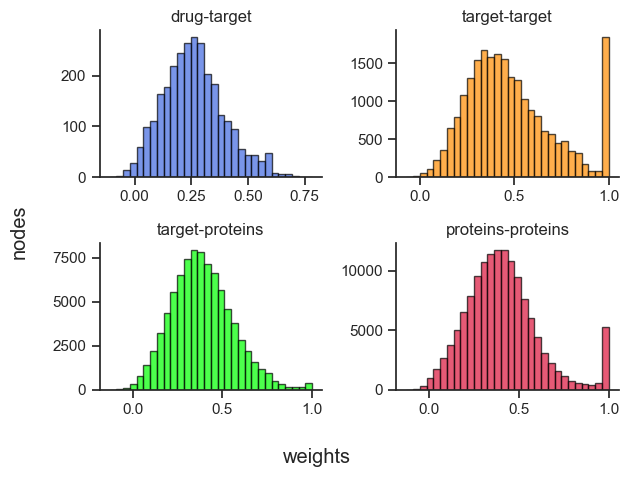

In [61]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].hist(drug_targets_edges_values, bins=30, color='royalblue', edgecolor='black', alpha=0.7)
axs[0, 0].set_title("drug-target")
axs[0, 1].hist(targets_targets_edges_values, bins=30, color='darkorange', edgecolor='black', alpha=0.7)
axs[0, 1].set_title("target-target")
axs[1, 0].hist(target_proteins_edges_values, bins=30, color='lime', edgecolor='black', alpha=0.7)
axs[1, 0].set_title("target-proteins")
axs[1, 1].hist(proteins_proteins_edges_values, bins=30, color='crimson', edgecolor='black', alpha=0.7)
axs[1, 1].set_title("proteins-proteins")

fig.supxlabel('weights')
fig.supylabel('nodes')

fig.tight_layout()
sns.despine()



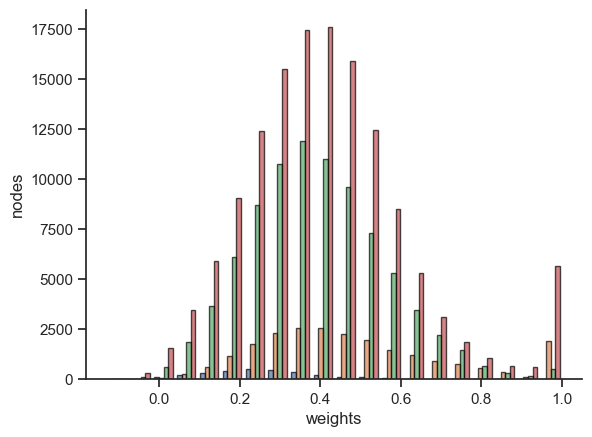

In [59]:
values = [drug_targets_edges_values, targets_targets_edges_values, target_proteins_edges_values, proteins_proteins_edges_values]

plt.hist(values, bins=20, edgecolor='black', alpha=0.7)
plt.xlabel("weights")
plt.ylabel("nodes")
sns.despine()